#Mount Gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

#Create symbolic link
!ln -s /content/gdrive/MyDrive/arima/ /mydrive
!ls /mydrive/

#Dependencies

In [ ]:
#Libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import datetime

import warnings
warnings.filterwarnings('ignore')

#Model Design Class

In [67]:
class newModule:
  def __init__(self, window, subject):
    self.window = window    #Past samples window
    self.subject = subject  #Data column

  #Function for model training  
  def fit(self):
    df = pd.read_pickle('/mydrive/data.pkl')  #Read data file
    time_series = df[self.subject]          #Fetch data column

    #Data normalization
    scaler = StandardScaler()
    scaler = scaler.fit(np.reshape(time_series.to_numpy(), newshape=(-1,1)))
    df_scaled = scaler.transform(np.reshape(time_series.to_numpy(), newshape=(-1,1)))
    
    #Train/Test split based on date
    Dates = pd.to_datetime(df['date'])      #Fetch date column
    start_date = datetime.datetime.strptime('2021-10-01', "%Y-%m-%d").date()
    end_date = datetime.datetime.strptime('2022-01-01', "%Y-%m-%d").date()
    #Total values to forecast
    duration =  (end_date-start_date).days

    #Train/Test split
    df_train = df_scaled[:len(df)-duration]
    self.df_test = df_scaled[len(df)-duration:]

                                    #XGBOOST MODEL
    #Value prediction step
    future_value = 1
    #Feature window size
    window_size = self.window

    #Create training set
    X_train, y_train = [], []
    #For loop over the timeseries data for conversion into windows
    for i in range(window_size, len(df_train)):
        X_train.append(df_train[i - window_size:i])
        y_train.append(df_train[i:i + future_value])
    #Convert to numpy array
    X_train, y_train = np.array(X_train), np.array(y_train)

    #Create test set
    X_test, y_test = [], []
    #For loop over the timeseries data for conversion into windows
    for i in range(window_size, len(self.df_test)):
        X_test.append(self.df_test[i - window_size:i])
        y_test.append(self.df_test[i:i + future_value])
    #Convert to numpy array
    X_test, self.y_test = np.array(X_test), np.array(y_test)


    # Model Declaration
    xgb_model = XGBRegressor(max_depth=6, learning_rate=0.1,
                     objective='reg:squarederror',
                     booster='dart',min_child_weight=3,
                     subsample=0.8,
                     reg_alpha=0.3,
                     reg_lambda=0.1
                     )
    #Model Training
    xgb_model.fit(np.squeeze(X_train), y_train)

    #Model prediction on train data
    xgb_forecast_train = xgb_model.predict(np.squeeze(X_train))
    #Rescaling normalized predictions
    self.xgb_predictions_train = scaler.inverse_transform(np.reshape(np.asarray(xgb_forecast_train), newshape=(-1,1)))
    self.True_values_train = scaler.inverse_transform(np.reshape(df_train, newshape=(-1,1)))

    #Model Prediction on test data
    xgb_forecast_test = xgb_model.predict(np.squeeze(X_test))
    #Rescaling normalized predictions
    self.xgb_forecast_test = xgb_forecast_test
    self.xgb_predictions_test = scaler.inverse_transform(np.reshape(np.asarray(xgb_forecast_test), newshape=(-1,1)))
    self.True_values_test = scaler.inverse_transform(np.reshape(self.df_test, newshape=(-1,1)))

                                               #ARIMA MODEL
    #Variable to store forecast values
    arima_forecast = []
    #Iterate over future values length
    for i in range(duration):
      #Declare model class
      arima_model = ARIMA(df_scaled[:len(df_train)+i], order=(self.window,0,0))
      #Model Training
      arima_fit = arima_model.fit()
      #Model forecast one value at a time
      arima_forecast.append(arima_fit.forecast(steps=future_value)[0].item())    
    #Rescale normalized values
    self.arima_forecast = np.reshape(np.asarray(arima_forecast), newshape=(-1,1))
    self.arima_forecast_scaled = scaler.inverse_transform(np.reshape(np.asarray(arima_forecast), newshape=(-1,1)))

    #Forecast Dates
    predict_period_dates = pd.date_range(list(Dates)[-duration], periods=duration, freq='1d').tolist()
    forecast_dates = []
    for time_i in predict_period_dates:
        forecast_dates.append(time_i.date())
    self.forecast_dates = forecast_dates

  #Function for storing xgboost predictions
  def xgboost(self):
    #Create Dataframe of the Forecasted values    
    df_forecast = pd.DataFrame({'Date':np.array(self.forecast_dates[self.window:len(self.True_values_test)-1]), 'True value':np.squeeze(self.True_values_test[self.window:len(self.True_values_test)-1]), 'Predictions':np.abs(np.floor(np.squeeze(self.xgb_predictions_test[1:])))})
    df_forecast.to_csv('xgb_forecast.csv')

  #Function for storing arima predictions
  def arima(self):
    #Create Dataframe of the Forecasted values    
    df_forecast = pd.DataFrame({'Date':np.array(self.forecast_dates[self.window:len(self.True_values_test)-1]), 'True value':np.squeeze(self.True_values_test[self.window:len(self.True_values_test)-1]), 'Predictions':np.abs(np.floor(np.squeeze(self.arima_forecast_scaled[self.window+1:])))})
    df_forecast.to_csv('arima_forecast.csv')

  #Calculate Mean Average Percentage Error (MAPE)
  def MAPE(self):
    #XGBoost mape score
    xgb_mape = (sum(abs(self.xgb_forecast_test-np.squeeze(self.y_test)))/len(self.y_test))*100
    #Arima mape score
    arima_mape = (sum(abs(self.arima_forecast[1:]-self.df_test[:len(self.df_test)-1]))/(len(self.df_test)-1))*100
    #Return values
    return xgb_mape, arima_mape.item()

  #Calculate Mean Squared Error
  def MSE(self):
    #XGBoost MSE score
    xgb_mse = sum(np.square(self.xgb_forecast_test-np.squeeze(self.y_test)))/len(self.y_test)
    #Arima MSE score
    arima_mse = sum(np.square(self.arima_forecast[1:]-self.df_test[:len(self.df_test)-1]))/(len(self.df_test)-1)
    #Return values
    return xgb_mse, arima_mse.item()

  #Plot forecasting results for training set
  def plot_train(self):
    plt.figure(figsize=(15,6))
    plt.plot(self.True_values_train[self.window:])
    plt.plot(self.xgb_predictions_train)
    plt.xlabel('Days')
    plt.ylabel('Clicks')
    plt.legend(['True values', 'XGB Forecast'])
    plt.title('XGB_Forecast on Training Set')
    plt.grid()

  #Plot forecasting results for test set
  def plot_test(self):
    plt.figure(figsize=(15,6))
    plt.plot(self.forecast_dates[self.window:len(self.True_values_test)-1] ,self.True_values_test[self.window:len(self.True_values_test)-1])
    plt.plot(self.forecast_dates[self.window:len(self.True_values_test)-1] ,self.xgb_predictions_test[1:])
    plt.plot(self.forecast_dates[self.window:len(self.True_values_test)-1] ,self.arima_forecast_scaled[self.window+1:])
    plt.xlabel('Date')
    plt.ylabel('Clicks')
    plt.title('Forecast on Test Dataset')
    plt.legend(['True values', 'XGB Forecast', 'ARIMA Forecast'])
    plt.grid()

#Main Function

In [62]:
#Past window size
windows = [3,7]
#Data columns
data = ['h0','h1','h2','h3','h4','h5','h6','h7','h8','h9']

#Iterating over windows
for i in windows:
  #Variables to store MAPE and MSE scores
  MAPE, MSE = [], []
  #Iterating over data columns
  for j in data:
    #Class instance
    obj = newModule(i,j)
    #Models training
    obj.fit()
    #Store MAPE and MSE scores
    MAPE.append(obj.MAPE())
    MSE.append(obj.MSE())
  #Get xgboost scores
  xgb_mape = [i[0] for i in MAPE]
  xgb_mse = [i[0] for i in MSE]
  #Get arima scores
  arima_mape = [i[1] for i in MAPE]
  arima_mse = [i[1] for i in MSE]
  #Store MAPE and MSE scores to data frames
  globals()['xgboost%s' % i] = pd.DataFrame(data=[xgb_mape,xgb_mse], columns=data, index=['MAPE', 'MSE']).round(decimals=2)
  globals()['arima%s' % i] = pd.DataFrame(data=[arima_mape,arima_mse], columns=data, index=['MAPE', 'MSE']).round(decimals=2)

#Results
##MAPE and MSE Scores

In [63]:
xgboost3

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9
MAPE,46.61,72.59,54.29,97.03,54.08,55.27,54.05,66.33,87.23,67.48
MSE,1.57,3.24,1.25,3.64,1.18,1.82,1.45,2.11,2.55,1.68


In [64]:
xgboost7

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9
MAPE,46.39,69.34,59.00,98.07,41.98,53.61,42.94,56.69,75.46,65.56
MSE,1.67,3.28,1.47,3.71,0.82,1.95,1.02,1.54,1.90,1.83


In [65]:
arima3

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9
MAPE,38.67,45.17,27.86,52.79,36.72,39.85,38.87,38.89,49.14,49.5
MSE,0.64,1.54,0.26,1.23,0.38,0.99,0.47,0.58,0.63,0.9


In [66]:
arima7

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9
MAPE,37.30,54.37,27.4,70.50,35.35,39.67,39.45,40.38,65.77,51.44
MSE,0.64,1.95,0.3,1.73,0.36,1.02,0.49,0.60,0.87,0.91


##Training and Test Plots
###Window size = 3

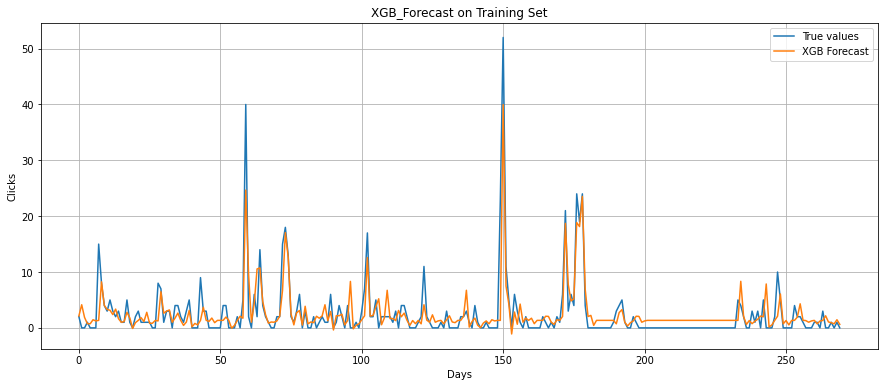

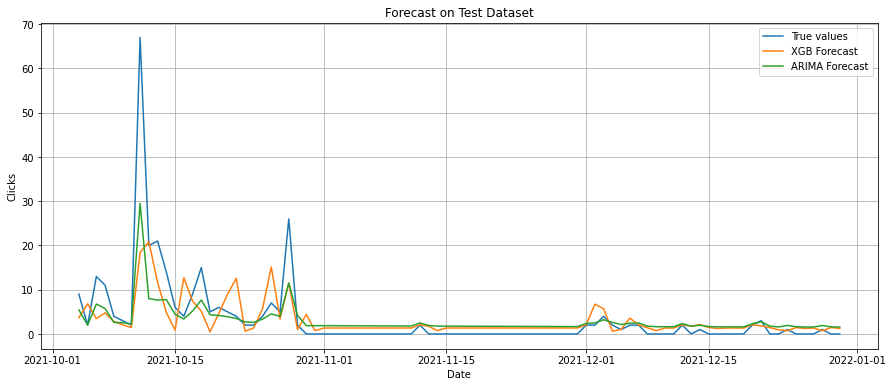

In [68]:
obj=newModule(3,'h0')
obj.fit()
obj.plot_train()
obj.plot_test()

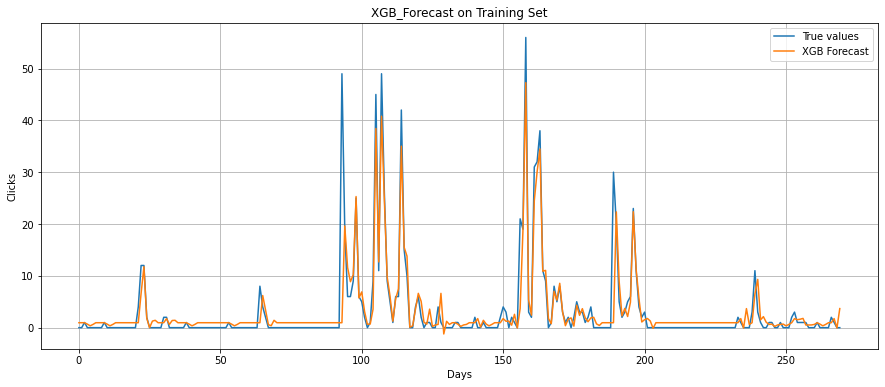

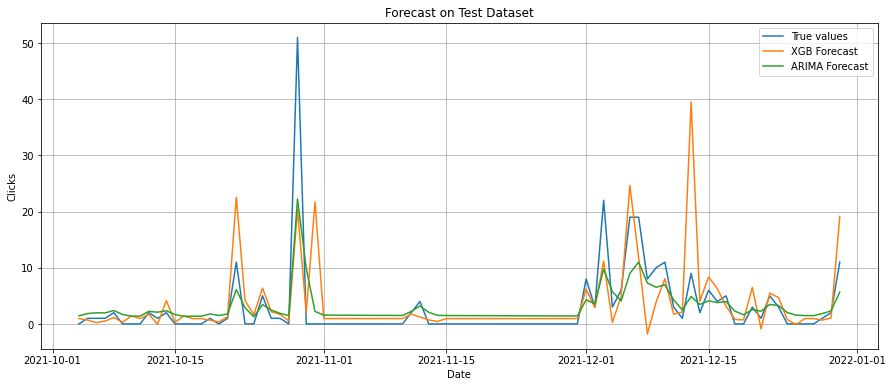

In [69]:
obj=newModule(3,'h2')
obj.fit()
obj.plot_train()
obj.plot_test()

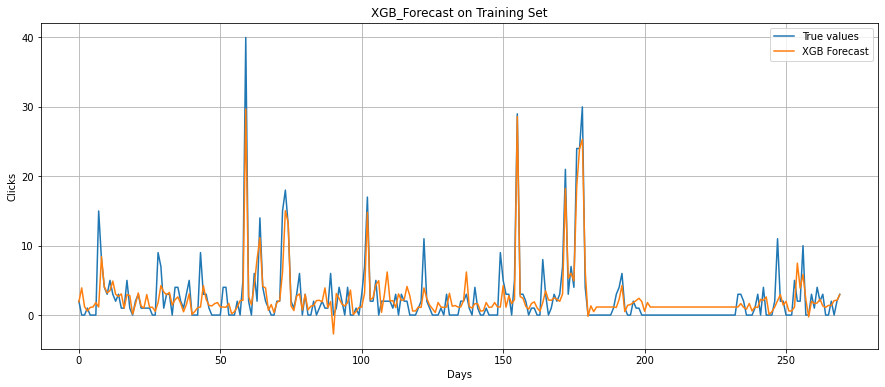

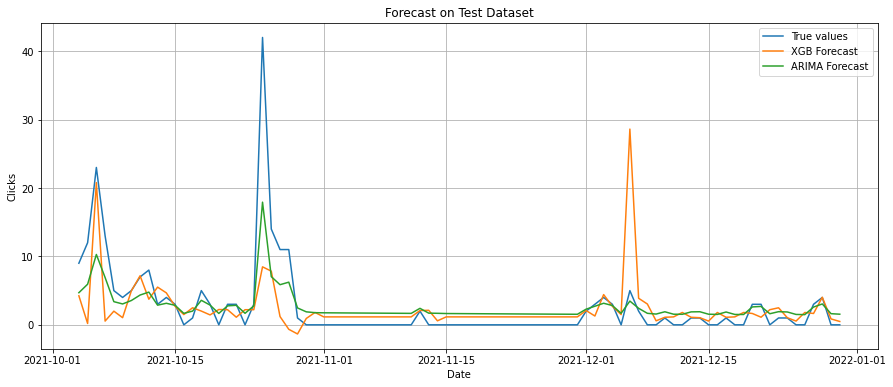

In [71]:
obj=newModule(3,'h6')
obj.fit()
obj.plot_train()
obj.plot_test()

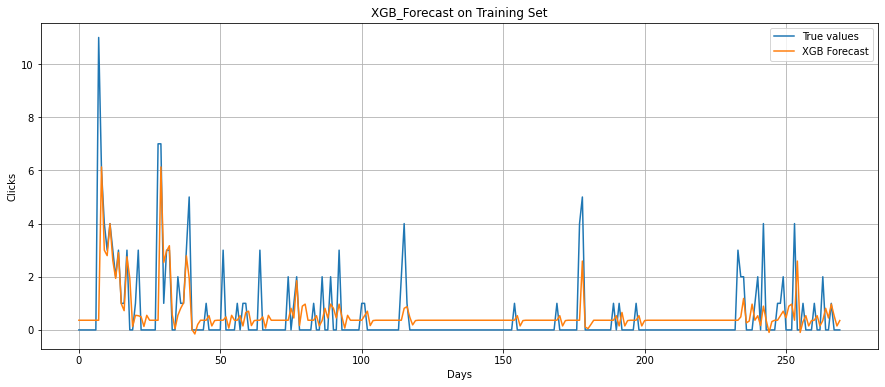

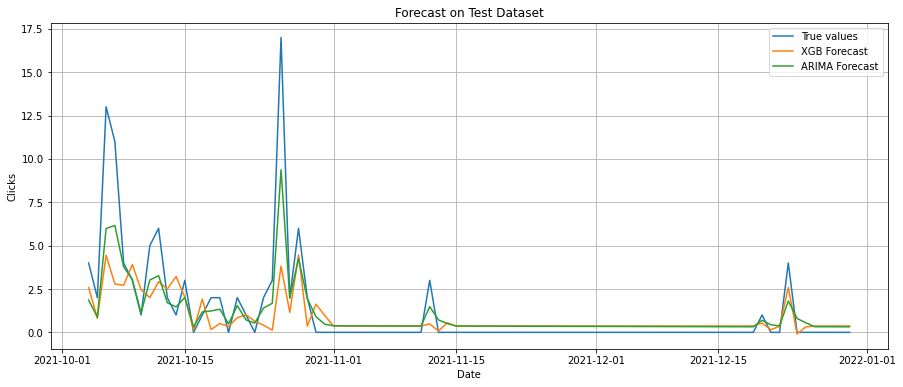

In [72]:
obj=newModule(3,'h7')
obj.fit()
obj.plot_train()
obj.plot_test()

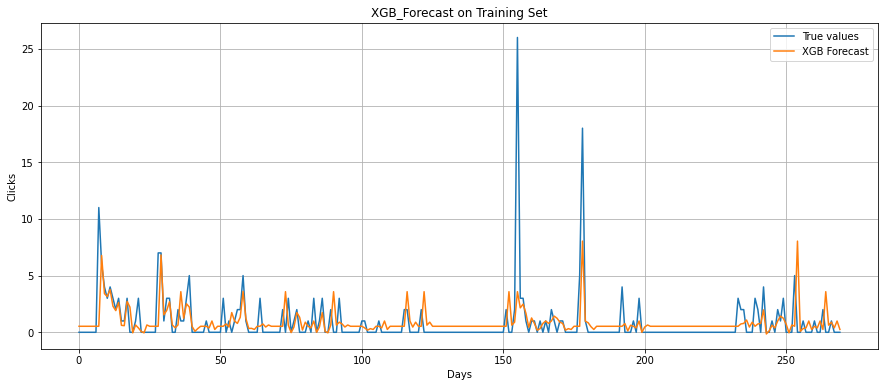

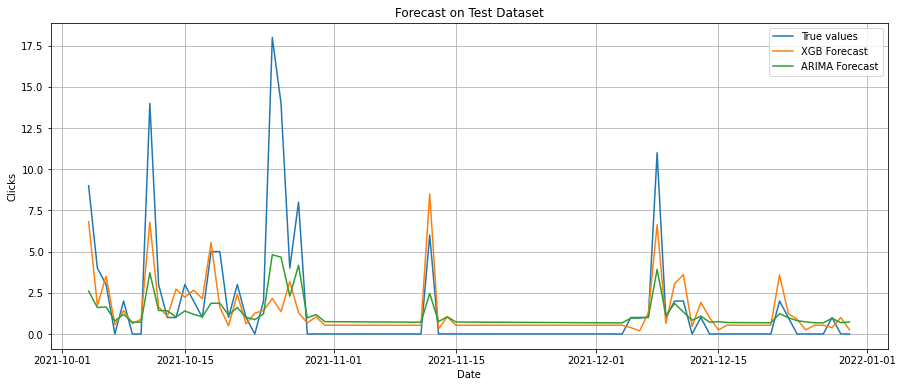

In [73]:
obj=newModule(3,'h9')
obj.fit()
obj.plot_train()
obj.plot_test()

###Window size = 7

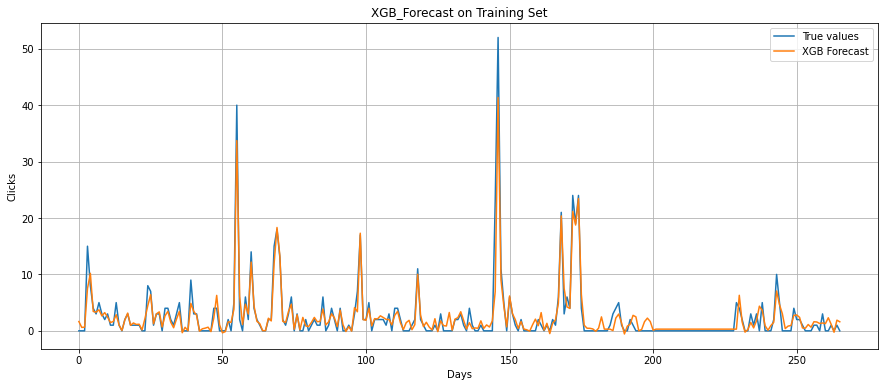

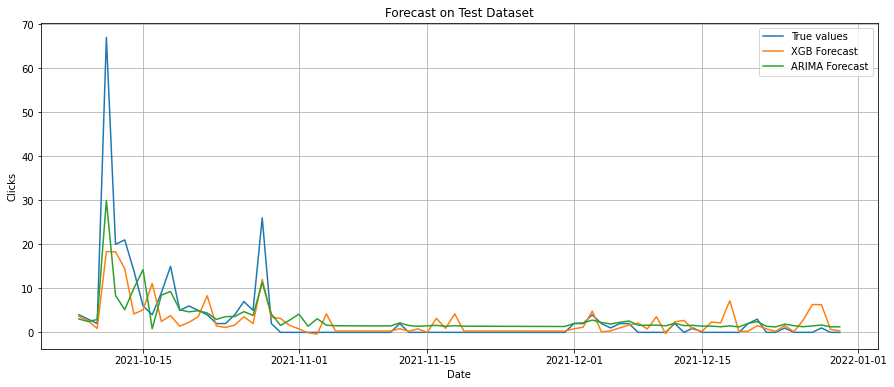

In [74]:
obj=newModule(7,'h0')
obj.fit()
obj.plot_train()
obj.plot_test()

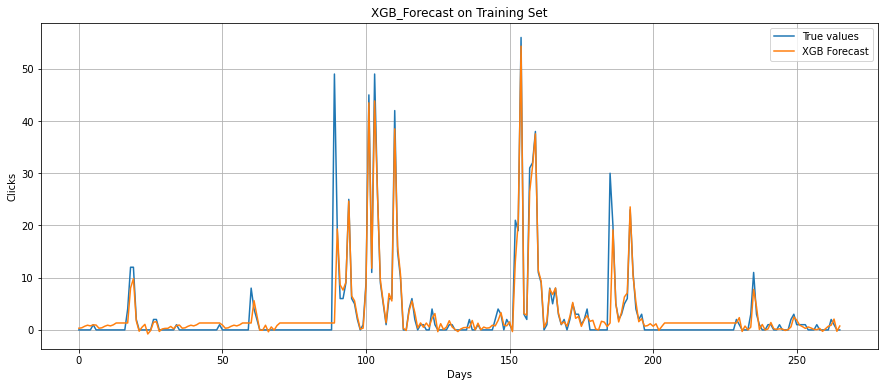

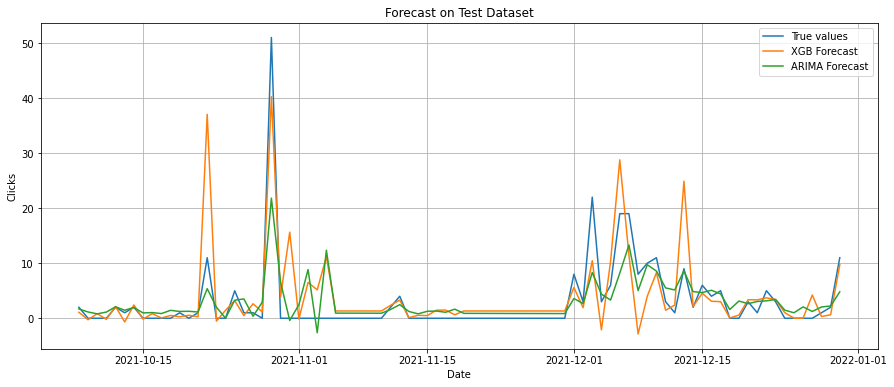

In [75]:
obj=newModule(7,'h2')
obj.fit()
obj.plot_train()
obj.plot_test()

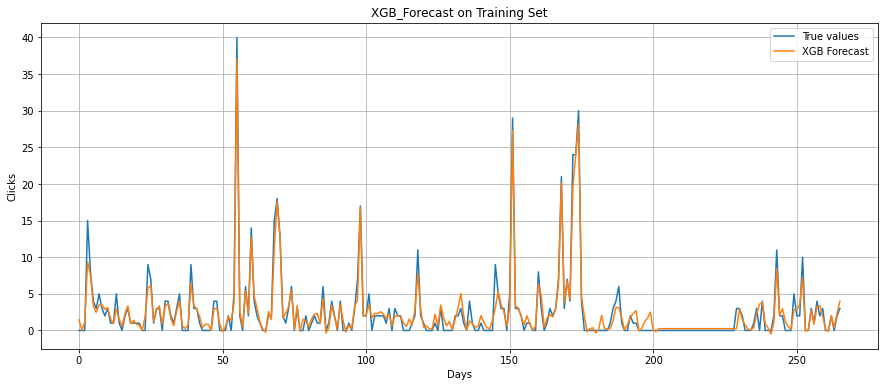

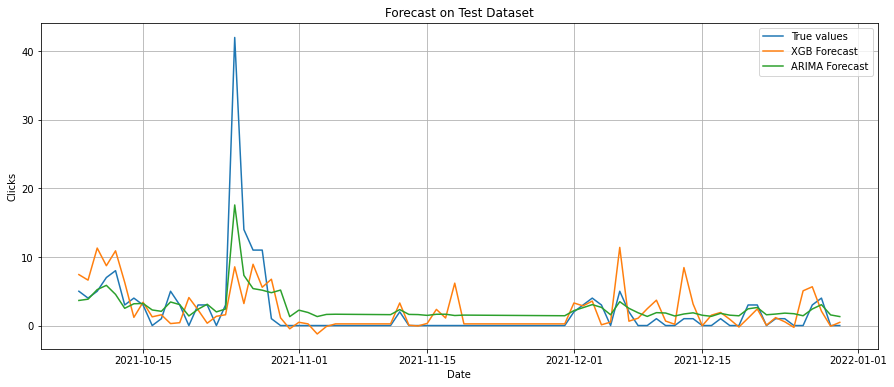

In [76]:
obj=newModule(7,'h6')
obj.fit()
obj.plot_train()
obj.plot_test()

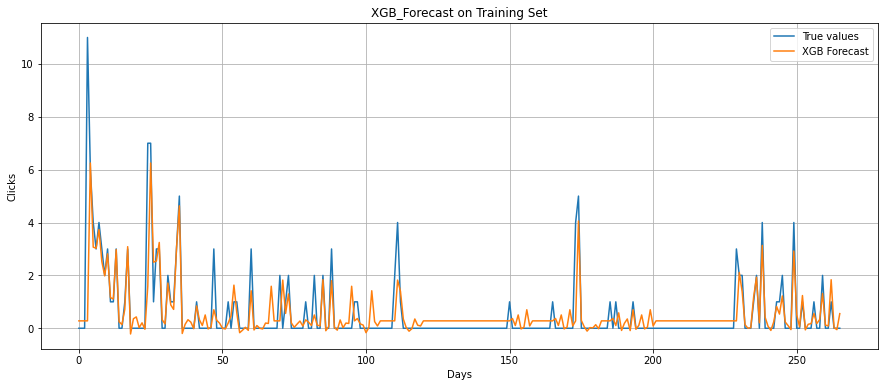

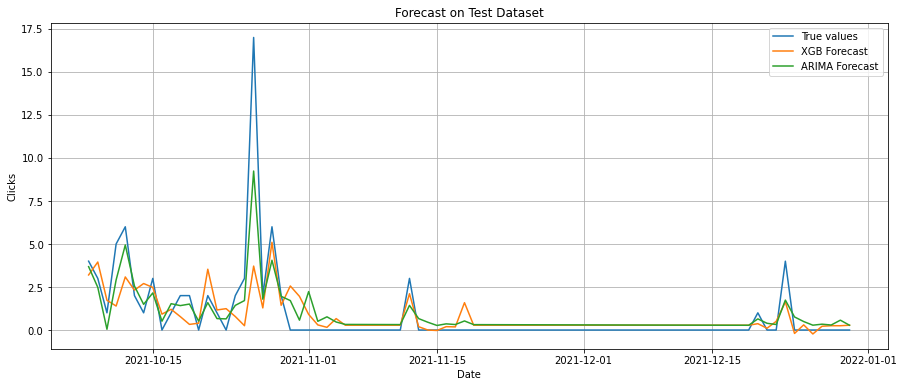

In [77]:
obj=newModule(7,'h7')
obj.fit()
obj.plot_train()
obj.plot_test()

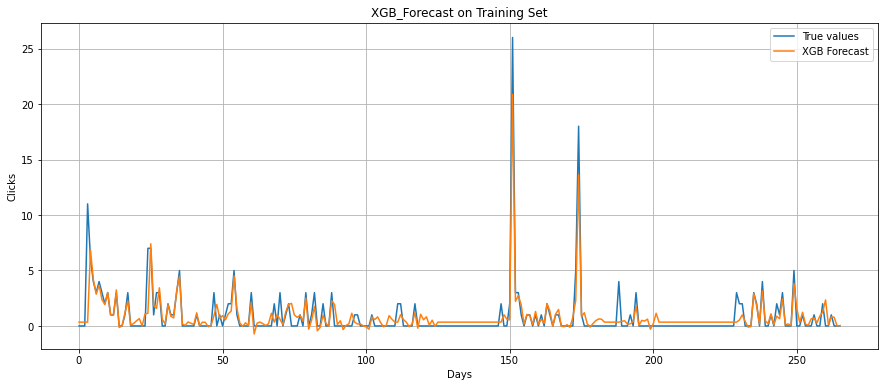

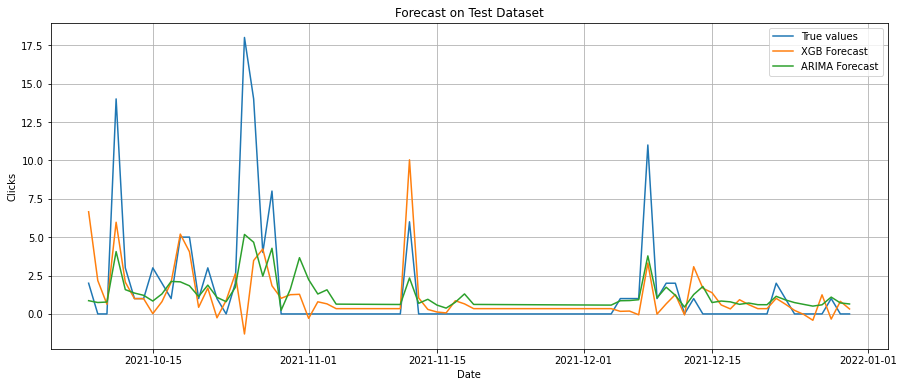

In [78]:
obj=newModule(7,'h9')
obj.fit()
obj.plot_train()
obj.plot_test()